# Gesture Recognition - Project
<h6>Author : Anshul Awasthi</h6>

## Problem Statement:

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
<br></br>
<pre>
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

    - Thumbs up:  Increase the volume
    - Thumbs down: Decrease the volume
    - Left swipe: 'Jump' backwards 10 seconds
    - Right swipe: 'Jump' forward 10 seconds  
    - Stop: Pause the movie
</pre>

Each video is a sequence of 30 frames (or images). 

# Understanding the Dataset:

- The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 
<br></br>
- Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.
<br></br>
- The task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects). We have withheld the test folder for evaluation purposes - your final model's performance will be tested on the 'test' set.
<br></br>

# Objective of the project:
- <b>Generator:</b>  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.
<br></br>
- <b>Model:</b> Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.
<br></br>
- <b>Write up:</b> This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 
<br></br>

In [36]:
# Checking the GPU configuration
!nvidia-smi

Wed Dec  4 00:41:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                Off | 00000000:1C:00.0 Off |                  Off |
| 35%   38C    P2              41W / 230W |   5214MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [37]:
# Importing the necessary libraries

import numpy as np
import os
# from scipy.misc import imread, imresize   # imread, imresize fucntions are deprecated from the scipy
                                            # misc library. Therefore, importing the above fucntions 
                                            # from supported libraries
from imageio import imread # replacement for, scipy.misc import imread
from skimage.transform import resize # replacement for, scipy.misc import imresize
import datetime
import os
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [38]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30) # deprecated
tf.random.set_seed(30)

In [39]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# importing some other libraries which will be needed for model building.

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
                                    Dense,
                                    GRU,
                                    Flatten,
                                    TimeDistributed,
                                    BatchNormalization,
                                    Activation,
                                    Conv3D,
                                    MaxPooling3D,
                                    Conv2D,
                                    MaxPooling2D,
                                    LSTM,
                                    Dropout,
                                    Input,
                                    GlobalAveragePooling3D,
                                    GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
# batch_size = #experiment with the batch size

In [41]:
# Checking the number of GPUs available
def gpu_check():
  physical_devices = tf.config.list_physical_devices('GPU')
  print("Num of currently available GPUs:", len(physical_devices))

gpu_check()

Num of currently available GPUs: 1


In [42]:
# source path
project_folder='datasets/Project_data'

In [43]:
# Building a plotting function to visually measure the accuracy and loss

def plot_evaluation(history):
    """
    Visualizes training and validation loss and accuracy metrics from a Keras training history.

    Args:
        history: A Keras History object returned by model.fit().
                 The history contains metrics such as loss and accuracy for both
                 training and validation over each epoch.

    Behavior:
        - Creates two subplots:
            1. Left plot: Training and validation loss.
            2. Right plot: Training and validation categorical accuracy.
        - Legends are added to distinguish between training and validation metrics.

    Example Usage:
        history = model.fit(train_data, validation_data=val_data, epochs=10)
        plot(history)
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))  # fig - Refers to the overall 
                                                                # figure object (the container).
                                                                # axes - Refers to the individual 
                                                                # subplot(s) within the figure.

    #Plot loss
    axes[0].plot(history.history['loss']) # Stored in the attribute history.history as a dictionary
    axes[0].plot(history.history['val_loss']) 
    axes[0].legend(['loss', 'val_loss'])
    axes[0].set_title('Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    
    # Plot categorical accuracy
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    axes[1].set_title("Categorical Accuracy Over Epochs")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    
    # Display the plots
    plt.tight_layout()
    plt.show()      

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [44]:
class ModelBuilder(metaclass=abc.ABCMeta):
    """
    A base class for building, training, and managing deep learning models.

    Attributes:
        train_doc (list): Shuffled list of training sample metadata from train.csv.
        val_doc (list): Shuffled list of validation sample metadata from val.csv.
        train_path (str): Path to the training dataset directory.
        val_path (str): Path to the validation dataset directory.
        num_train_sequences (int): Number of training samples.
        num_val_sequences (int): Number of validation samples.
        image_height (int): Height of resized images.
        image_width (int): Width of resized images.
        channels (int): Number of color channels (default is 3 for RGB).
        num_classes (int): Number of output classes for classification.
        total_frames (int): Total number of frames per video.
        frames_to_sample (int): Number of frames to sample from each video.
        batch_size (int): Number of samples processed in each batch.
        num_epochs (int): Number of training epochs.

    Methods:
        initialize_path(project_folder): Initializes paths to training/validation data and counts sequences.
        initialize_image_properties(image_height, image_width): Sets image properties (dimensions, channels).
        initialize_hyperparams(frames_to_sample, batch_size, num_epochs): Sets hyperparameters for training.
        generator(source_path, folder_list, augment): Creates a generator for batch processing.
        one_batch_data(source_path, t, batch, batch_size, img_idx, augment, remaining_seq): Processes one batch of data.
        train_model(model, augment_data): Trains the model using the defined generators and callbacks.
        define_model(): Abstract method for defining the model architecture (to be implemented by subclasses).
    """

    # Initializing the paths where project data resides
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path = project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # Initializing the image properties
    def initialize_image_properties(self, image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    # Initializing hyperparameters for training
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    # Generator function for creating batches
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(
                    source_path, t, batch, batch_size, img_idx, augment
                )
                yield batch_data, batch_labels

            remaining_seq = len(t) % batch_size
            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(
                    source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq
                )
                yield batch_data, batch_labels

    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_len, self.num_classes))

        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len):
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                # Read and resize image using modern libraries
                image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3), anti_aliasing=True)

                # Normalize image
                batch_data[folder, idx, :, :, :] = image_resized / 255.0

                if augment:
                    shifted = cv2.warpAffine(
                        image,
                        np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]),
                        (image.shape[1], image.shape[0]),
                    )

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped = shifted[x0:x1, y0:y1, :]
                    image_resized = resize(cropped, (self.image_height, self.image_width, 3), anti_aliasing=True)

                    batch_data_aug[folder, idx, :, :, :] = image_resized / 255.0

            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
        lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1)
        early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

        callbacks_list = [checkpoint, lr_reduction, early_stop]

        steps_per_epoch = (self.num_train_sequences + self.batch_size - 1) // self.batch_size
        validation_steps = (self.num_val_sequences + self.batch_size - 1) // self.batch_size

        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=self.num_epochs,
            callbacks=callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
        )
        return history

    @abc.abstractmethod
    def define_model(self):
        pass


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [22]:
class Model_Conv3D_1(ModelBuilder):  # Subclassing ModelBuilder

    def define_model(self):
        """
        Defines a 3D Convolutional Neural Network (CNN) for video data.
        
        Returns:
            model (Sequential): The compiled Keras model.
        """
        model = Sequential()
        
        # Adding Input Layer
        model.add(Input(shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))

        # 1st Conv3D Layer
        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))  # ReLU activation for non-linearity
        model.add(BatchNormalization())  # Normalize feature maps to speed up training
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Down-sampling to reduce spatial dimensions
        
        # 2nd Conv3D Layer
        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # 3rd Conv3D Layer
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # 4th Conv3D Layer
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Flatten the 3D feature maps into a 1D vector
        model.add(Flatten())

        # Dense Layer 1
        model.add(Dense(128, activation='relu'))  # Fully connected layer with 128 units
        model.add(BatchNormalization())  # Normalize activations
        model.add(Dropout(0.5))  # Dropout to prevent overfitting
        
        # Dense Layer 2
        model.add(Dense(64, activation='relu'))  # Fully connected layer with 64 units
        model.add(BatchNormalization())
        model.add(Dropout(0.25))  # Less aggressive dropout

        # Output Layer
        model.add(Dense(self.num_classes, activation='softmax'))  # Softmax for multi-class classification

        # Optimizer
        optimiser = optimizers.Adam()  # Adam optimizer
        # Compile the model
        model.compile(optimizer=optimiser, 
                      loss='categorical_crossentropy',  # Loss function for multi-class classification
                      metrics=['categorical_accuracy'])  # Metric to evaluate performance

        return model

    
# Model_Conv3D_1 is a subclass of ModelBuilder.
# It inherits all attributes and methods from ModelBuilder.
# This means Model_Conv3D_1 has access to methods like:
        # initialize_path
        # initialize_image_properties
        # initialize_hyperparams
        # generator
        # train_model
# Additionally, it must implement the define_model method, which was marked as abstract in ModelBuilder.
# define_model is an abstract method defined in the ModelBuilder class
# It is a placeholder that forces any subclass of ModelBuilder to provide its own implementation


In [23]:
conv_3d1=Model_Conv3D_1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)   

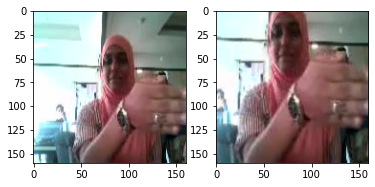

In [26]:
### Test run 
test_generator=Model_Conv3D_1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,9,:,:,:])   
axes[1].imshow(batch_data[3,9,:,:,:]) 
plt.show()

## Further, testing with Image resolution, number of frames, and batch_size to be used

In [31]:
conv_3d1.train_model(conv_3d1_model)

67/67 [==============================] - ETA: 0s - loss: 1.2893 - categorical_accuracy: 0.4902
Epoch 00001: val_loss improved from inf to 7.45171, saving model to model_init_2024-12-0211_26_15.222863/model-00001-1.28934-0.49020-7.45171-0.16000.h5
67/67 [==============================] - 173s 3s/step - loss: 1.2893 - categorical_accuracy: 0.4902 - val_loss: 7.4517 - val_categorical_accuracy: 0.1600 - lr: 0.0010


### From the above output we can say that:
<pre>
    - Training Accuracy: 49.02% (Moderate, showing the model has started learning).
    - Validation Accuracy: 16.00% (Very low, indicating poor generalization to unseen data).
    - Validation Loss: 7.4517 (High, showing a significant gap between training and validation loss).
    - Training Loss: 1.2893 (Reasonable, as it's much lower than the validation loss).
    
</pre>

This discrepancy between training and validation metrics suggests that the model is overfitting or underfitting due to potential issues in data preparation, model complexity, or training settings. Moreover, Insufficient Training Epochs. Training for just one epoch is insufficient for the model to learn meaningful patterns.

## The following experiments analyze how training time is influenced by image resolution, the number of images in a sequence, and batch size.

#### Purpose of Testing:
<pre>
Running the given model with the described architecture and hyperparameters serves the following purposes:

    - Evaluate Model Functionality: Verify that the model architecture, data pipeline, and training loop are set up correctly and that no critical errors occur during execution.
    - Assess Initial Model Performance: Test the model's ability to learn patterns from the data, even with minimal epochs. Metrics like training loss, validation loss, and accuracy give a sense of the model's performance.
    - Identify Weaknesses in the Current Setup: Highlight potential issues like overfitting, underfitting, or data preprocessing problems. The large gap between training and validation metrics indicates possible areas for improvement.

In [38]:
## Testing with 100 x 100 image size, frames_to_sample=16,batch_size=30 and num_epochs=2

In [35]:
conv_3d1=Model_Conv3D_1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.7347 - categorical_accuracy: 0.3771
Epoch 00001: val_loss improved from inf to 2.34522, saving model to model_init_2024-12-0211_44_47.941509/model-00001-1.73470-0.37707-2.34522-0.16000.h5
23/23 [==============================] - 83s 4s/step - loss: 1.7347 - categorical_accuracy: 0.3771 - val_loss: 2.3452 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.1662 - categorical_accuracy: 0.5686
Epoch 00002: val_loss did not improve from 2.34522
23/23 [==============================] - 80s 4s/step - loss: 1.1662 - categorical_accuracy: 0.5686 - val_loss: 4.7814 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [39]:
## Testing with 160 x 160 image size, frames_to_sample=30,batch_size=15 and num_epochs=2

In [37]:
conv_3d1=Model_Conv3D_1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6630 - categorical_accuracy: 0.4012
Epoch 00001: val_loss improved from inf to 5.30762, saving model to model_init_2024-12-0211_56_27.970759/model-00001-1.66295-0.40121-5.30762-0.16000.h5
45/45 [==============================] - 172s 4s/step - loss: 1.6630 - categorical_accuracy: 0.4012 - val_loss: 5.3076 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0662 - categorical_accuracy: 0.5852
Epoch 00002: val_loss did not improve from 5.30762
45/45 [==============================] - 174s 4s/step - loss: 1.0662 - categorical_accuracy: 0.5852 - val_loss: 8.3539 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [40]:
## Testing with 120 x 120 image size, frames_to_sample=16,batch_size=30 and num_epochs=2

In [ ]:
conv_3d1=Model_Conv3D_1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.5787 - categorical_accuracy: 0.3922
Epoch 00001: val_loss improved from inf to 1.87027, saving model to model_init_2024-12-0212_13_19.214172/model-00001-1.57871-0.39216-1.87027-0.16000.h5
23/23 [==============================] - 83s 4s/step - loss: 1.5787 - categorical_accuracy: 0.3922 - val_loss: 1.8703 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.0489 - categorical_accuracy: 0.6109
Epoch 00002: val_loss did not improve from 1.87027
23/23 [==============================] - 80s 4s/step - loss: 1.0489 - categorical_accuracy: 0.6109 - val_loss: 2.9162 - val_categorical_accuracy: 0.1500 - lr: 0.0010


### Insights
These hyperparameters directly impact:

- Model Training Time: Higher resolution and more frames significantly increase computation.
- Model Performance: Larger resolutions and more frames generally improve model accuracy by capturing more spatial and temporal information.
- Resource Utilization: Balancing batch size with resolution and frames ensures efficient GPU/CPU usage.


<pre>
1. Testing with 100x100, 16 frames, batch size 30, 2 epochs
    Training Accuracy: 61.09%
    Validation Accuracy: 15.00%
Observation: Fast training due to lower resolution but poor generalization.

2. Testing with 160x160, 30 frames, batch size 15, 2 epochs
    Training Accuracy: 58.52%
    Validation Accuracy: 16.00%
Observation: Higher resolution and more frames provided richer spatial and temporal information, but training time increased significantly. Overfitting persisted.

3. Testing with 120x120, 16 frames, batch size 30, 2 epochs
Training Accuracy: 61.09%
Validation Accuracy: 15.00%
Observation: Moderate resolution and fewer frames led to a balance in training time, but validation accuracy remained low.

Insights: The resolution 120x120 might work well if coupled with improved data augmentation or better regularization.


## Model 1
Base Model - Batch Size = 40 and No. of Epochs = 16. Further, changing the filter size to (3,3,3), fixing dropout to 0.25 and the dense layers with 64 neurons and default learning_rate=0.001

In [45]:
class Model_Conv3D_1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        
        # Adding Input Layer
        model.add(Input(shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))

        # 1st Conv3D Layer
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # 2nd Conv3D Layer
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # 3rd Conv3D Layer
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # 4th Conv3D Layer
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Flatten the 3D feature maps into a 1D vector
        model.add(Flatten())
        
        # Dense Layer 1
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        # Dense Layer 2
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer
        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [46]:
conv_3d1=Model_Conv3D_1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=16)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_44 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_33 (Activation)  (None, 10, 80, 80, 32)   

In [47]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/16
17/17 [==============================] - ETA: 0s - loss: 1.6158 - categorical_accuracy: 0.4087
Epoch 00001: val_loss improved from inf to 1.64248, saving model to model_init_2024-12-0212_35_23.217112/model-00001-1.61582-0.40875-1.64248-0.22000.h5
17/17 [==============================] - 117s 7s/step - loss: 1.6158 - categorical_accuracy: 0.4087 - val_loss: 1.6425 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/16
17/17 [==============================] - ETA: 0s - loss: 1.0385 - categorical_accuracy: 0.6139
Epoch 00002: val_loss did not improve from 1.64248
17/17 [==============================] - 111s 7s/step - loss: 1.0385 - categorical_accuracy: 0.6139 - val_loss: 1.8376 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/16
17/17 [==============================] - ETA: 0s - loss: 0.7840 - categorical_accuracy: 0.7134
Epoch 00003: val_loss did not improve from 1.64248
17/17 [==============================] - 110s 7s/step - loss: 0.7840 - c

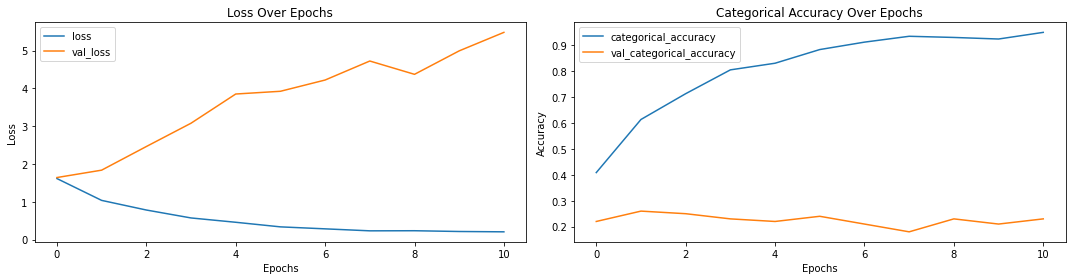

In [48]:
plot_evaluation(history_model1)

### Insights for Model 1

Training Metrics:
- Training Accuracy: 95.02% at Epoch 11.
- The model shows strong performance on the training data, achieving high accuracy.
- Training Loss: 0.2073 at Epoch 11.
- The low training loss indicates the model is fitting the training data well.

Validation Metrics:
- Validation Accuracy: 23.00% at Epoch 11.
- The validation accuracy is significantly lower than the training accuracy, indicating poor generalization.
- Validation Loss: 5.4803 at Epoch 11.
- The high validation loss further highlights the model's inability to generalize to unseen data.

Early Stopping: 
- The model stopped training at Epoch 11 due to early stopping.
- Reason: The validation loss did not improve after multiple epochs, showing signs of overfitting.

<pre>
Key Issues
Overfitting: The model performs exceptionally well on the training data but struggles on the validation data. The widening gap between training and validation metrics indicates overfitting.

## Model 2
Reducing the filter size to (2,2,2), image resolution to 120 x 120, - Batch Size = 30, No. of Epochs = 25 and lr=0.0002

In [51]:
class Model_Conv3D_2(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        
        # Adding Input Layer
        model.add(Input(shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))

        # 1st Conv3D Layer
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # 2nd Conv3D Layer
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # 3rd Conv3D Layer
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # 4th Conv3D Layer
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        # Flatten the 3D feature maps into a 1D vector
        model.add(Flatten())
        
        # Dense Layer 1
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        # Dense Layer 2
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer
        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
conv_3d2=Model_Conv3D_2()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=120,image_width=120)
conv_3d2.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_56 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_41 (Activation)  (None, 8, 60, 60, 32)   

In [53]:
print("Total Parameters:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Parameters: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.0823 - categorical_accuracy: 0.3386
Epoch 00001: val_loss improved from inf to 1.97689, saving model to model_init_2024-12-0213_23_59.583852/model-00001-2.08225-0.33861-1.97689-0.21000.h5
23/23 [==============================] - 151s 7s/step - loss: 2.0823 - categorical_accuracy: 0.3386 - val_loss: 1.9769 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.5760 - categorical_accuracy: 0.4729
Epoch 00002: val_loss did not improve from 1.97689
23/23 [==============================] - 148s 7s/step - loss: 1.5760 - categorical_accuracy: 0.4729 - val_loss: 2.7990 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2130 - categorical_accuracy: 0.5490
Epoch 00003: val_loss did not improve from 1.97689
23/23 [==============================] - 165s 7s/step - loss

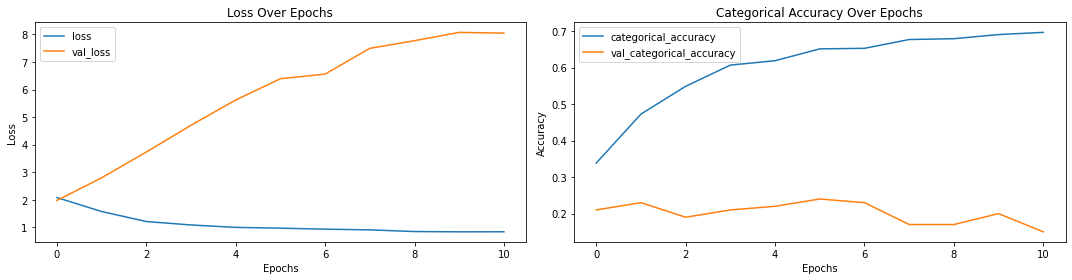

In [55]:
plot_evaluation(history_model2)

### Insights for Model 2

<hr>

- Training Accuracy: By the 11th epoch, training accuracy reached 69.68%, indicating that the model is capable of learning from the training data.
- Validation Accuracy: Validation accuracy remains low (15.00%), showing the model struggles to generalize to unseen data.
- Validation Loss: Validation loss increased to 8.0433, indicating potential overfitting or issues with learning from validation data.
- Early Stopping: Early stopping was triggered at epoch 11, as validation loss stopped improving for several epochs. The patience set for early stopping effectively prevented unnecessary computations.
- High Complexity: The model might be too complex (too many trainable parameters), causing it to overfit the training data.


## Model 3
Modifying the filter size to (3, 3, 3), image resolution to 120 x 120, Batch Size = 20, No. of Epochs = 25 and lr=0.0001

In [11]:
class Model_Conv3D_3(ModelBuilder):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=128, dropout=0.4):
        model = Sequential()
        
        # Input Layer
        model.add(Input(shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        # 1st Conv3D Layer
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.3))  # Early dropout to prevent overfitting

        # 2nd Conv3D Layer
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.3))

        # 3rd Conv3D Layer
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.4))

        # 4th Conv3D Layer
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.4))

        # Global Average Pooling
        model.add(GlobalAveragePooling3D())

        # Dense Layer 1
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Dense Layer 2
        model.add(Dense(dense_neurons // 2, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Output Layer
        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
# Define parameters
conv_3d3 = Model_Conv3D_3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120, image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=25)
conv_3d3_model = conv_3d3.define_model(filtersize=(3, 3, 3), dense_neurons=128, dropout=0.4)

# Print summary
conv_3d3_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 8, 60, 60, 16)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)    

In [16]:
# Train model
print("Total Parameters:", conv_3d3_model.count_params())
history_model3 = conv_3d3.train_model(conv_3d3_model, augment_data=True)

Total Parameters: 318661
Epoch 1/25


2024-12-02 14:57:17.065158: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 2.0351 - categorical_accuracy: 0.2934
Epoch 00001: val_loss improved from inf to 2.11107, saving model to model_init_2024-12-0214_57_09.462728/model-00001-2.03509-0.29336-2.11107-0.21000.h5
34/34 [==============================] - 155s 5s/step - loss: 2.0351 - categorical_accuracy: 0.2934 - val_loss: 2.1111 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6148 - categorical_accuracy: 0.3748
Epoch 00002: val_loss did not improve from 2.11107
34/34 [==============================] - 154s 5s/step - loss: 1.6148 - categorical_accuracy: 0.3748 - val_loss: 3.7191 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.5082 - categorical_accuracy: 0.4110
Epoch 00003: val_loss did not improve from 2.11107
34/34 [==============================] - 152s 5s/step - loss: 1.5082 - categorical_accuracy: 0.4110 - val

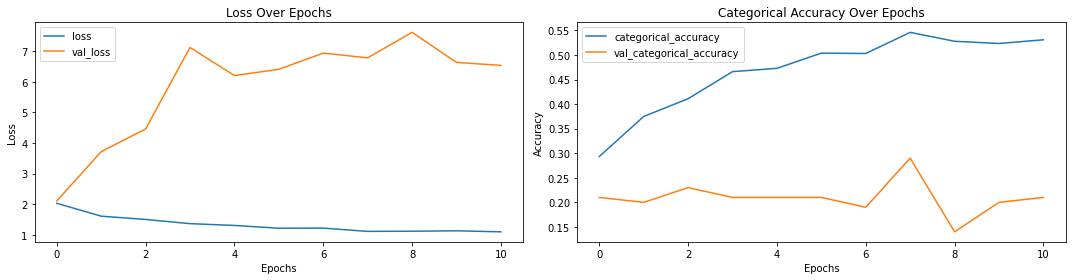

In [17]:
plot_evaluation(history_model3)

### Insights for Model 3
<hr>
Training Performance:

- Training Loss: 1.1042
- Training Accuracy: 53.09%
- The training accuracy shows the model is learning patterns from the data, but it hasn't reached optimal performance.

Validation Performance:

- Validation Loss: 6.5333
- Validation Accuracy: 21.00%
- The validation accuracy is much lower than the training accuracy, indicating potential overfitting.

Early Stopping: Early stopping was triggered at epoch 11 as the validation loss did not improve. The validation loss increased significantly after epoch 11, showing the model struggles to generalize on unseen data.

Overfitting: The large gap between training accuracy (53.09%) and validation accuracy (21.00%) suggests the model is overfitting to the training data.
Possible causes include insufficient regularization, lack of diverse data augmentation, or over-complexity of the model for the given dataset.

High Validation Loss: The validation loss increased significantly, indicating the model's inability to predict accurately on the validation dataset.

## Model 4
Modifying the filter size to (3, 3, 3), image resolution to 120 x 120, Batch Size = 20, No. of Epochs = 15 and lr=0.0001

In [19]:
class Model_Conv3D_4(ModelBuilder):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=128, dropout=0.5):
        model = Sequential()
        
        # Input Layer
        model.add(Input(shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        # Conv3D Layers
        model.add(Conv3D(16, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Global Average Pooling
        model.add(GlobalAveragePooling3D())

        # Dense Layers
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d_4=Model_Conv3D_4()
conv_3d_4.initialize_path(project_folder)
conv_3d_4.initialize_image_properties(image_height=120,image_width=120)
conv_3d_4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d_4_model=conv_3d_4.define_model(dense_neurons=64,dropout=0.25)
# Print summary
conv_3d_4_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_11 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_12 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_12 (Activation)  (None, 8, 60, 60, 32)    

In [26]:
# Train model
print("Total Parameters:", conv_3d_4_model.count_params())
history_model_4 = conv_3d_4.train_model(conv_3d_4_model, augment_data=True)

Total Parameters: 75717
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 2.1227 - categorical_accuracy: 0.4118
Epoch 00001: val_loss improved from inf to 2.32779, saving model to model_init_2024-12-0217_43_22.802893/model-00001-2.12270-0.41176-2.32779-0.18000.h5
34/34 [==============================] - 171s 5s/step - loss: 2.1227 - categorical_accuracy: 0.4118 - val_loss: 2.3278 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.8491 - categorical_accuracy: 0.5038
Epoch 00002: val_loss did not improve from 2.32779
34/34 [==============================] - 183s 6s/step - loss: 1.8491 - categorical_accuracy: 0.5038 - val_loss: 2.4141 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.6768 - categorical_accuracy: 0.5679
Epoch 00003: val_loss did not improve from 2.32779
34/34 [==============================] - 165s 5s/step - loss: 1.6768 -

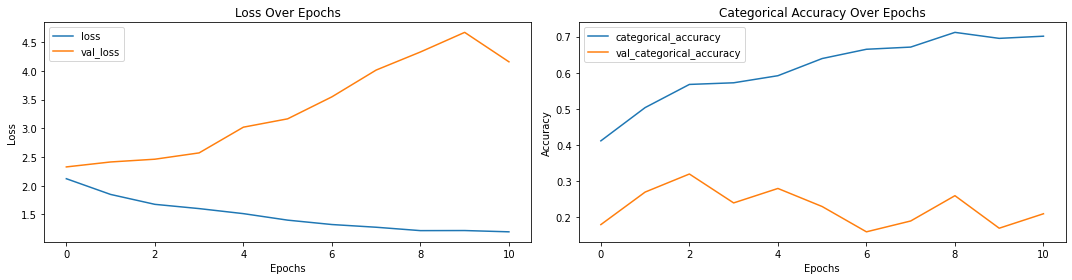

In [28]:
plot_evaluation(history_model_4)

### Insight for Model 4
<hr>

Training Accuracy vs Validation Accuracy:
- The training accuracy steadily improves, reaching 71.14% by epoch 11.
- Validation accuracy is stagnant at low levels, never exceeding 32% and even dropping to 17% in later epochs.
- This is a clear sign of overfitting: the model learns the training data well but fails to generalize to unseen validation data.

Validation Loss Behavior: 
- Validation loss starts at 2.33, improves initially, but then begins to worsen, reaching 4.67 by epoch 10.
- Even with learning rate reductions (via ReduceLROnPlateau), the validation loss does not improve significantly.
- This indicates that the model struggles to capture the underlying patterns in the validation set.
Learning Rate Decay:
- The learning rate starts at 0.001, reduces to 0.0002, and then to 0.00004.
- Despite these reductions, the model does not improve its validation performance, suggesting other architectural or parameter adjustments are needed.<br></br>
Potential Causes of Poor Generalization:
Regularization Effects: The use of kernel_regularizer with l2(0.01) might be too aggressive, causing the model to underutilize its capacity.
Insufficient Frames in Sequence: Using 16 frames might not capture enough temporal information, especially for complex tasks like gesture recognition.
Model Complexity: With only 75,717 parameters, the model might be too simplistic for the task, leading to insufficient feature learning.


## Model 5
Modifying the filter size to (3, 3, 3), image resolution to 160 x 160, Batch Size = 16, No. of Epochs = 20 and lr=0.0005

In [11]:
class Model_Conv3D_5(ModelBuilder):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=128, dropout=0.5):
        model = Sequential()

        # Input Layer
        model.add(Input(shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))

        # Conv3D Layers
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(256, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Global Average Pooling
        model.add(GlobalAveragePooling3D())

        # Dense Layers
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0005)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
# Initialize the new model
conv_3d_5 = Model_Conv3D_5()
conv_3d_5.initialize_path(project_folder)
# Update the image properties for higher resolution
conv_3d_5.initialize_image_properties(image_height=160, image_width=160) # 160×160 for more spatial detail.
# Adjust the hyperparameters based on suggestions
conv_3d_5.initialize_hyperparams(
    frames_to_sample=20,  # Increased frames to capture more temporal information
    batch_size=16,        # Reduced batch size for better gradient updates
    num_epochs=20         # Slightly increased epochs for improved training
)

# Define the new model with modified architecture and hyperparameters
conv_3d_5_model = conv_3d_5.define_model(
    dense_neurons=128,    # More neurons for improved representation learning
    dropout=0.3,          # Adjusted dropout for better regularization
)
# Print summary
conv_3d_5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 32)  2624      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 64)    55360     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 64)    0

2024-12-02 18:53:50.892340: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-12-02 18:53:50.892401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [13]:
gpu_check()

Num of currently available GPUs: 1


In [14]:
# Train model
print("Total Parameters:", conv_3d_5_model.count_params())
history_model_5 = conv_3d_5.train_model(conv_3d_5_model, augment_data=True)

Total Parameters: 1200261
Epoch 1/20


2024-12-02 18:54:26.104125: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.4271 - categorical_accuracy: 0.4502
Epoch 00001: val_loss improved from inf to 2.02425, saving model to model_init_2024-12-0218_54_19.287493/model-00001-1.42710-0.45023-2.02425-0.24000.h5
42/42 [==============================] - 244s 6s/step - loss: 1.4271 - categorical_accuracy: 0.4502 - val_loss: 2.0243 - val_categorical_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.1275 - categorical_accuracy: 0.5535
Epoch 00002: val_loss did not improve from 2.02425
42/42 [==============================] - 256s 6s/step - loss: 1.1275 - categorical_accuracy: 0.5535 - val_loss: 2.7997 - val_categorical_accuracy: 0.1900 - lr: 5.0000e-04
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.0210 - categorical_accuracy: 0.6018
Epoch 00003: val_loss did not improve from 2.02425
42/42 [==============================] - 229s 6s/step - loss: 1.0210 - categorical_accuracy: 0.60

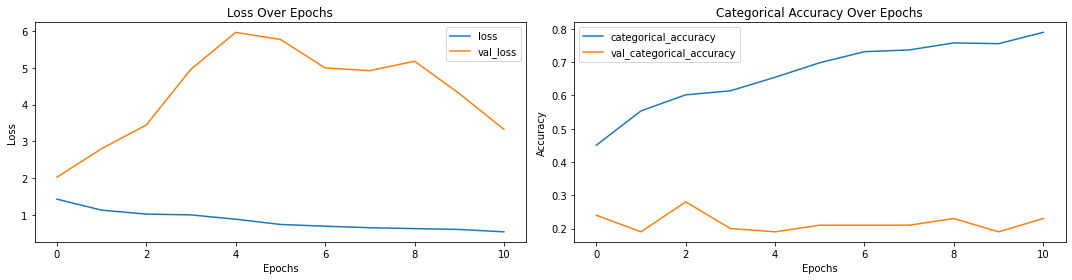

In [15]:
plot_evaluation(history_model_5)

### Insights for Model 5

- Training Accuracy Progress: The training accuracy steadily improves from 45.02% to 78.96% by the 11th epoch, indicating that the model is learning effectively on the training data.

- Validation Accuracy and Loss: The validation accuracy started at 24%, peaked briefly at 28%, but then plateaued or declined, indicating overfitting.

- Validation loss improved in the first epoch but degraded significantly afterward, confirming that the model isn't generalizing well to unseen data.

- Learning Rate Adjustment: ReduceLROnPlateau decreased the learning rate twice during training, indicating that the model hit a plateau and struggled to optimize further.

- Early Stopping: The model stopped early at the 11th epoch due to no improvement in validation loss, preventing unnecessary computation.

- Possible Overfitting: The training loss and accuracy improve significantly, but the validation metrics don't follow suit, suggesting overfitting.

## Model 6
Modifying and increasing the filter size to (4, 4, 4) to capture complex features, image resolution to 160 x 160, Batch Size = 16, No. of Epochs = 25 and lr=0.0002

In [ ]:
class Model_Conv3D_6(ModelBuilder):
    def define_model(self, filtersize=(4, 4, 4), dense_neurons=128, dropout=0.4):
        model = Sequential()
        
        # Input Layer
        model.add(Input(shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        # Conv3D Layers
        model.add(Conv3D(16, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (4, 4, 4), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Global Average Pooling
        model.add(GlobalAveragePooling3D())

        # Dense Layers
        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d_6 = Model_Conv3D_6()
conv_3d_6.initialize_path(project_folder)
conv_3d_6.initialize_image_properties(image_height=160, image_width=160)
conv_3d_6.initialize_hyperparams(frames_to_sample=20, batch_size=16, num_epochs=25)
conv_3d_6_model = conv_3d_6.define_model(dense_neurons=128, dropout=0.4)
conv_3d_6_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  3088      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    32800     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [20]:
# Train Model
print("Total Parameters:", conv_3d_6_model.count_params())
history_model_6 = conv_3d_6.train_model(conv_3d_6_model, augment_data=True)

Total Parameters: 710069
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 4.2142 - categorical_accuracy: 0.4087
Epoch 00001: val_loss improved from inf to 4.33646, saving model to model_init_2024-12-0220_03_07.704680/model-00001-4.21419-0.40875-4.33646-0.16000.h5
42/42 [==============================] - 243s 6s/step - loss: 4.2142 - categorical_accuracy: 0.4087 - val_loss: 4.3365 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 3.8684 - categorical_accuracy: 0.4985
Epoch 00002: val_loss did not improve from 4.33646
42/42 [==============================] - 255s 6s/step - loss: 3.8684 - categorical_accuracy: 0.4985 - val_loss: 4.5249 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 3.7325 - categorical_accuracy: 0.5354
Epoch 00003: val_loss did not improve from 4.33646
42/42 [==============================] - 220s 5s/step - loss:

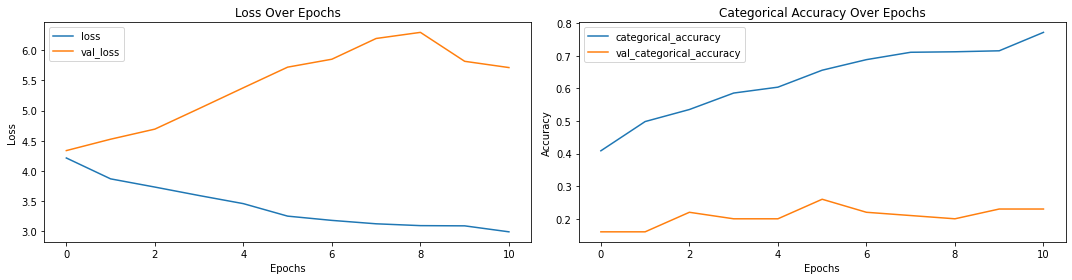

In [21]:
plot_evaluation(history_model_6)

## Insights for Model 6:

- Overfitting: The model demonstrated a significant gap between training (77.2%) and validation (23%) accuracy, indicating overfitting despite regularization.

- Validation Loss Plateau: Minimal improvement in validation loss after the first epoch suggests limitations in learning capacity or hyperparameters.

- Filter Configuration: The uniform filter size (4, 4, 4) across all layers may not effectively capture hierarchical spatial and temporal features.

<pre>
Reason for moving to the next model:
To address overfitting, improve generalization, and explore optimized configurations for better hierarchical feature extraction.

## Model  7
Modifying the filter size to (3, 3, 3), image resolution to 120 x 120, Batch Size = 32, No. of Epochs = 30 and lr=0.0005

In [27]:
class Model_Conv3D_7(ModelBuilder):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=128, dropout=0.5):
        model = Sequential()
        
        # Input Layer
        model.add(Input(shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        # Conv3D Layers
        model.add(Conv3D(16, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # Global Average Pooling
        model.add(GlobalAveragePooling3D())

        # Dense Layers
        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        
        model.add(Dense(dense_neurons // 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout / 2))  # Set dropout to 0.25 for the second layer


        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0005)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
# Initialize the Model
conv_3d_7 = Model_Conv3D_7()

conv_3d_7.initialize_path(project_folder)
conv_3d_7.initialize_image_properties(image_height=120, image_width=120)
# Set Hyperparameters
conv_3d_7.initialize_hyperparams(frames_to_sample=20, batch_size=32, num_epochs=30)
conv_3d_7_model = conv_3d_7.define_model(dense_neurons=128, dropout=0.4)

# Print the Model Summary
conv_3d_7_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_27 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_21 (Activation)  (None, 10, 60, 60, 32)   

In [31]:
# Train Model
print("Total Parameters:", conv_3d_7_model.count_params())

history_model_7 = conv_3d_7.train_model(
    conv_3d_7_model, 
    augment_data=True
)

Total Parameters: 163013
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 3.6574 - categorical_accuracy: 0.3175
Epoch 00001: val_loss improved from inf to 3.41442, saving model to model_init_2024-12-0221_37_17.906110/model-00001-3.65735-0.31750-3.41442-0.22000.h5
21/21 [==============================] - 197s 10s/step - loss: 3.6574 - categorical_accuracy: 0.3175 - val_loss: 3.4144 - val_categorical_accuracy: 0.2200 - lr: 5.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 3.2539 - categorical_accuracy: 0.4193
Epoch 00002: val_loss did not improve from 3.41442
21/21 [==============================] - 187s 9s/step - loss: 3.2539 - categorical_accuracy: 0.4193 - val_loss: 3.4453 - val_categorical_accuracy: 0.1500 - lr: 5.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 3.0779 - categorical_accuracy: 0.4442
Epoch 00003: val_loss did not improve from 3.41442
21/21 [==============================] - 187s 9s/step - loss

### Insights for Model 7:

- Regularization and Dropout: The model incorporated improved regularization (L2) and adjusted dropout layers, which helped stabilize training but still showed overfitting with a significant gap between training accuracy (~68%) and validation accuracy (20%).

- Learning Rate Adjustments: The ReduceLROnPlateau callback effectively reduced the learning rate during training, but the model struggled to improve validation loss, indicating potential limitations in the model's capacity or data representation.

- Filter and Architecture Limitations: The use of a fixed (3,3,3) filter for most layers, with a shift to (2,2,2) for the final Conv3D layer, improved granularity but did not fully resolve the generalization issue.

<pre>
Reason for Moving to the Next Version:
To explore advanced configurations, such as deeper architectures, dynamic learning rates, or transfer learning, that could better address generalization challenges and further refine feature extraction for complex temporal-spatial patterns.

## Model  8 - CNN - LSTM Model

Core Structure: Combines Conv2D layers for spatial feature extraction and LSTM for temporal sequence learning, leveraging TimeDistributed to apply convolution operations across sequential frames.

Key Parameters:

- LSTM Cells: 128, for capturing temporal dependencies.
- Dropout: 0.25, added for regularization to reduce overfitting.
- Learning Rate: 0.0005, carefully chosen for stable convergence.

In [32]:
class RNN_CNN_1(ModelBuilder):
    """
    A CNN-LSTM model for sequential data, leveraging Conv2D layers for spatial feature extraction 
    and LSTM for temporal sequence learning.
    """

    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        model = Sequential()

        # Input Layer using TimeDistributed to apply Conv2D across time steps
        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Second Conv2D layer with TimeDistributed for sequence processing
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Third Conv2D layer
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Fourth Conv2D layer
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Fifth Conv2D layer
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Flatten the Conv2D outputs for LSTM processing
        model.add(TimeDistributed(Flatten()))

        # LSTM layer for temporal feature extraction
        model.add(LSTM(lstm_cells, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
        model.add(Dropout(dropout))

        # Fully Connected Dense Layer
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        # Output Layer with softmax activation for classification
        model.add(Dense(self.num_classes, activation='softmax'))

        # Optimizer and Compilation
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Adjustable learning rate
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [33]:
# Initialize parameters
rnn_cnn1 = RNN_CNN_1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120, image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=20)

# Define the model
rnn_cnn1_model = rnn_cnn1.define_model(lstm_cells=128, dense_neurons=128, dropout=0.25)
# Model Summary
rnn_cnn1_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [34]:
# Train the Model
print("Total Parameters:", rnn_cnn1_model.count_params())
history_model_rnn_cnn1 = rnn_cnn1.train_model(rnn_cnn1_model, augment_data=True)

Total Parameters: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3925 - categorical_accuracy: 0.4050
Epoch 00001: val_loss improved from inf to 1.68306, saving model to model_init_2024-12-0222_35_21.050333/model-00001-1.39249-0.40498-1.68306-0.21000.h5
34/34 [==============================] - 184s 5s/step - loss: 1.3925 - categorical_accuracy: 0.4050 - val_loss: 1.6831 - val_categorical_accuracy: 0.2100 - lr: 5.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0887 - categorical_accuracy: 0.5732
Epoch 00002: val_loss did not improve from 1.68306
34/34 [==============================] - 176s 5s/step - loss: 1.0887 - categorical_accuracy: 0.5732 - val_loss: 1.9367 - val_categorical_accuracy: 0.2100 - lr: 5.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9479 - categorical_accuracy: 0.6146
Epoch 00003: val_loss did not improve from 1.68306
34/34 [==============================] - 176s 5s/step - loss

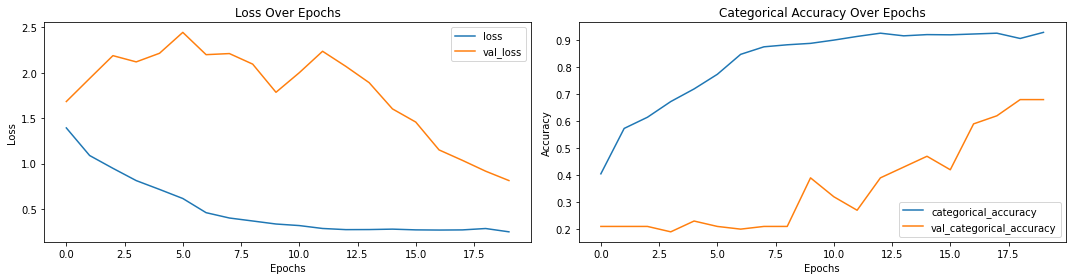

In [35]:
plot_evaluation(history_model_rnn_cnn1)

### Insights for Model 8:

Initial Observations:

- The model starts with a reasonable training accuracy of 40.5% and improves to 92.9% by the end of 20 epochs.
- Validation accuracy improves significantly towards the later epochs, reaching 68%, with a val_loss of 0.813.

- Learning Rate Adjustment: The model responds well to the learning rate decay triggered by ReduceLROnPlateau. This adjustment likely helped it escape suboptimal local minima.

- Valuation Gap: Although the training accuracy is high, the validation accuracy suggests some overfitting. The model may be focusing too much on the training data and not generalizing perfectly to the validation set.

- Val_loss Trend: The validation loss steadily improves after epoch 15, indicating the model continues to learn relevant patterns as the training progresses.

Final Results:
- Training accuracy: ~92.9%
- Validation accuracy: ~68.0%
- Indicates reasonable performance, but there is room for improvement, particularly in generalization.

<pre>
Reason for moving to the next Model:
The gap between training and validation performance suggests limited regularization and architectural complexity, necessitating a deeper exploration with additional regularization and denser layers.

## Model  9 - CNN - LSTM

Enhanced Regularization:
- Added L2 regularization (0.002) to Conv2D and Dense layers to mitigate overfitting.
- Dropout increased to 0.3 in dense layers and reduced to 0.2 in the LSTM layer for better regularization balance.

Key Structural Changes:

- Additional Dense Layer: Splits neurons into two layers for finer-grained learning.
- Batch Normalization: Added to all Dense layers to stabilize training and improve performance.
- Higher Batch Size: Set to 32 for faster convergence and better gradient estimation.

In [12]:
class RNN_CNN_2(ModelBuilder):
    def define_model(self, lstm_cells=128, dense_neurons=128, dropout=0.3):
        model = Sequential()

        # Input Layer
        model.add(
            TimeDistributed(
                Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),
                input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels),
            )
        )
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Additional Conv2D Layers
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        # LSTM Layer
        model.add(LSTM(lstm_cells, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
        model.add(Dropout(0.2))  # Regularize the LSTM layer

        # Dense Layers
        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(dense_neurons // 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

        # Output Layer
        model.add(Dense(self.num_classes, activation='softmax'))

#         # Learning Rate Schedule
#         lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#             initial_learning_rate=0.0005, decay_steps=10, decay_rate=0.9, staircase=True
#         )
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0005)

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [13]:
# Initialize Parameters
rnn_cnn2 = RNN_CNN_2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120, image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=20, batch_size=32, num_epochs=30)

# Define the Model
rnn_cnn2_model = rnn_cnn2.define_model(lstm_cells=128, dense_neurons=128, dropout=0.3)

# Print Summary
rnn_cnn2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 60, 60, 32)  

In [14]:
# Train Model
print("Total Parameters:", rnn_cnn2_model.count_params())
history_model_rnn_cnn2 = rnn_cnn2.train_model(rnn_cnn2_model, augment_data=True)
# model_init_2024-12-0223_47_58.885563 --> deprecated

Total Parameters: 3401573
Epoch 1/30


2024-12-03 16:51:17.786760: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.6296 - categorical_accuracy: 0.3062
Epoch 00001: val_loss improved from inf to 2.33988, saving model to model_init_2024-12-0316_51_04.923544/model-00001-2.62963-0.30618-2.33988-0.23000.h5
21/21 [==============================] - 194s 9s/step - loss: 2.6296 - categorical_accuracy: 0.3062 - val_loss: 2.3399 - val_categorical_accuracy: 0.2300 - lr: 5.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 2.1000 - categorical_accuracy: 0.4796
Epoch 00004: val_loss did not improve from 2.33988
21/21 [==============================] - 185s 9s/step - loss: 2.1000 - categorical_accuracy: 0.4796 - val_loss: 2.3805 - val_categorical_accuracy: 0.1800 - lr: 5.0000e-04
Epoch 5/30
21/21 [==============================] - ETA: 0s - loss: 1.9815 - categorical_accuracy: 0.5234
Epoch 00014: val_loss did not improve from 2.33988
21/21 [==============================] - 202s 10s/step - loss: 1.5976 - categorical_accuracy: 0.6

### Insights for Model 9

- Performance Bottleneck: Despite incorporating L2 regularization and increasing model complexity, the validation loss did not improve significantly, indicating overfitting even with added regularization.

- Training-Validation Gap: A high training accuracy (~67%) with poor validation accuracy (29%) suggests that the model struggles to generalize effectively.

- Parameter Complexity: With over 3.4 million parameters, the model may be excessively complex for the current dataset, leading to overfitting without yielding corresponding improvements in validation performance.


<pre>
Reason for moving to next model:

Model 9 revealed that high parameter count and overly aggressive regularization (L2 on all Conv2D layers) can negatively impact generalization. 

Transitioning to Model 10 involves:
- Reducing LSTM and Dense neurons to simplify the architecture.
- Removing L2 regularization on Conv2D layers and retaining only Dropout to ensure balanced regularization.
- Streamlining architecture based on the lessons from earlier iterations, focusing on achieving a better balance between complexity and performance.


## Model 10 (CNN-LSTM)

Key Features:

- Simpler Architecture: LSTM cells reduced to 64, Dense neurons to 64, and dropout retained at 0.25 to prevent overfitting.
- Removed L2 Regularization: Only Dropout is used to address overfitting, eliminating excess regularization penalties.
- Balanced Layers: Five Conv2D layers with BatchNormalization and MaxPooling, followed by LSTM for sequence learning.

Differences from Previous Models:

- Compared to Model 8: Retains similar core structure but introduces more iterations.
- Compared to Model 9: Removes heavy regularization (L2) and simplifies layer configuration, addressing overfitting and parameter overhead.

In [15]:
class RNN_CNN_3(ModelBuilder):
    """
    A CNN-LSTM model for sequential data, leveraging Conv2D layers for spatial feature extraction 
    and LSTM for temporal sequence learning.
    """

    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        model = Sequential()

        # Input Layer using TimeDistributed to apply Conv2D across time steps
        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Second Conv2D layer with TimeDistributed for sequence processing
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Third Conv2D layer
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Fourth Conv2D layer
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Fifth Conv2D layer
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Flatten the Conv2D outputs for LSTM processing
        model.add(TimeDistributed(Flatten()))

        # LSTM layer for temporal feature extraction
        model.add(LSTM(lstm_cells, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
        model.add(Dropout(dropout))

        # Fully Connected Dense Layer
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        # Output Layer with softmax activation for classification
        model.add(Dense(self.num_classes, activation='softmax'))

        # Optimizer and Compilation
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Adjustable learning rate
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


### Activation functions in LSTM:-

- activation='tanh': is applied to the cell state Ct and hidden state ht, which scale the values between -1 and 1 to manage the magnitude of cell state and hidden state.
- recurrent_activation='sigmoid'
The sigmoid activation is used in the gates of the LSTM (forget gate, input gate, and output gate).
Purpose: Produces a value between 0 and 1, which acts as a probability to decide:
- How much information to keep (forget gate).
- How much information to add (input gate).
- How much information to output (output gate).

Why Two Activation Functions?

- tanh handles the cell state and hidden state transformations.
- sigmoid regulates the flow of information through the gates. This separation ensures the LSTM can process sequences effectively, balancing remembering and forgetting.


In [17]:
# Initialize parameters
rnn_cnn3 = RNN_CNN_3()
rnn_cnn3.initialize_path(project_folder)
rnn_cnn3.initialize_image_properties(image_height=120, image_width=120)
rnn_cnn3.initialize_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=30)

# Define the model
rnn_cnn3_model = rnn_cnn3.define_model(lstm_cells=128, dense_neurons=128, dropout=0.25)
# Model Summary
rnn_cnn3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 18, 60, 60, 32)  

In [19]:
# Train Model
print("Total Parameters:", rnn_cnn3_model.count_params())
history_model_rnn_cnn3 = rnn_cnn3.train_model(rnn_cnn3_model, augment_data=True)

Total Parameters: 1657445
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.3500 - categorical_accuracy: 0.4299
Epoch 00001: val_loss improved from inf to 1.71010, saving model to model_init_2024-12-0317_48_08.367885/model-00001-1.35002-0.42986-1.71010-0.21000.h5
34/34 [==============================] - 184s 5s/step - loss: 1.3500 - categorical_accuracy: 0.4299 - val_loss: 1.7101 - val_categorical_accuracy: 0.2100 - lr: 5.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0588 - categorical_accuracy: 0.5724
Epoch 00002: val_loss did not improve from 1.71010
34/34 [==============================] - 173s 5s/step - loss: 1.0588 - categorical_accuracy: 0.5724 - val_loss: 1.8548 - val_categorical_accuracy: 0.1800 - lr: 5.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9287 - categorical_accuracy: 0.6305
Epoch 00003: val_loss improved from 1.71010 to 1.66671, saving model to model_init_2024-12-0317_48_08.367885/mo

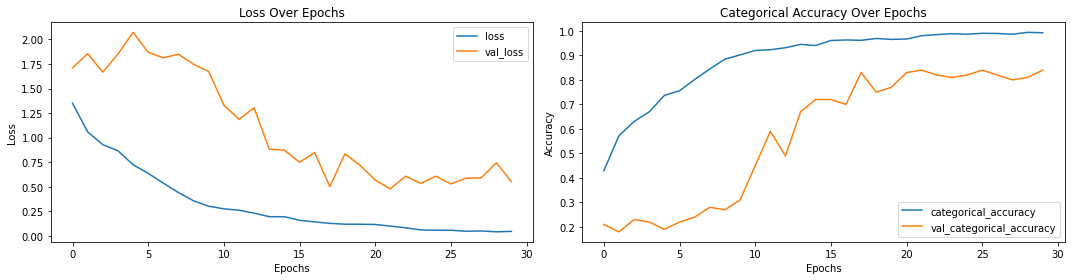

In [20]:
plot_evaluation(history_model_rnn_cnn3)

<h2> Training Insights</h2>
<hr>

<b>Model Performance:</b>
<ul style="list-style-type:square;">
    <li>Training Accuracy: Reached ~99.25% by the last epoch, indicating the model has learned the training data very well.</li>
    <li>Validation Accuracy: Stabilized around 84%, which is a strong performance, suggesting the model generalizes well.</li>
</ul>

<b>Validation Loss and Accuracy Trend:</b>
<ul style="list-style-type: square;">
    <li>The validation loss improved significantly from 1.7101 in the first epoch to 0.4792 in epoch 22.</li>
    <li>Validation accuracy showed steady improvement but plateaued after reaching 84%.</li>
</ul>

<b>Learning Rate Adjustment:</b>
<ui style="list-style-type: square;">
    <li>The ReduceLROnPlateau callback reduced the learning rate multiple times, helping the model fine-tune better at lower learning rates.</li>
    <li>Validation accuracy did not degrade after reducing the learning rate, suggesting that the model is learning at a consistent pace.</li>
</ui>

<b>Overfitting:</b>
<ul style="list-style-type: square;">
There is a slight indication of overfitting as the training accuracy reached 99%, while validation accuracy plateaued at 84%. This could be due to:
    <li>A complex model for the dataset.</li>
    <li>Insufficient regularization.</li>
</ul>

<b>Insights and Recommendations:</b>
Good Generalization: A validation accuracy of 84% is quite strong, especially for a sequential data model like CNN-LSTM. The gap between training accuracy (99%) and validation accuracy (~84%) indicates mild overfitting. Regularization and/or more data augmentation might help mitigate this further.

<pre>
Reason for moving to next model:
Will attempt to reduce overfitting by adding Regularization

## Model 11 (CNN-LSTM)

Enhanced Regularization:

- All Conv2D and Dense layers incorporate L2 regularization to control overfitting and improve generalization.

In [23]:
class RNN_CNN_4(ModelBuilder):
    """
    A CNN-LSTM model for sequential data, leveraging Conv2D layers for spatial feature extraction 
    and LSTM for temporal sequence learning.
    """

    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        model = Sequential()

        # Input Layer using TimeDistributed to apply Conv2D across time steps
        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', 
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                                  input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Second Conv2D layer with TimeDistributed for sequence processing
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Third Conv2D layer
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Fourth Conv2D layer
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Fifth Conv2D layer
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        # Flatten the Conv2D outputs for LSTM processing
        model.add(TimeDistributed(Flatten()))

        # LSTM layer for temporal feature extraction
        model.add(LSTM(lstm_cells, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
        model.add(Dropout(dropout))

        # Fully Connected Dense Layer with Regularization
        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Dropout(dropout))

        # Output Layer with softmax activation for classification
        model.add(Dense(self.num_classes, activation='softmax'))

        # Optimizer and Compilation
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Adjustable learning rate
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [24]:
# Initialize parameters
rnn_cnn4 = RNN_CNN_4()
rnn_cnn4.initialize_path(project_folder)
rnn_cnn4.initialize_image_properties(image_height=120, image_width=120)
rnn_cnn4.initialize_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=30)

# Define the model
rnn_cnn4_model = rnn_cnn4.define_model(lstm_cells=128, dense_neurons=128, dropout=0.25)
# Model Summary
rnn_cnn4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_58 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_61 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 18, 60, 60, 32)  

In [25]:
# Train Model
print("Total Parameters:", rnn_cnn4_model.count_params())
history_model_rnn_cnn4 = rnn_cnn4.train_model(rnn_cnn4_model, augment_data=True)

Total Parameters: 1657445
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 4.2255 - categorical_accuracy: 0.4087
Epoch 00001: val_loss improved from inf to 4.38706, saving model to model_init_2024-12-0320_10_21.857188/model-00001-4.22549-0.40875-4.38706-0.22000.h5
34/34 [==============================] - 202s 6s/step - loss: 4.2255 - categorical_accuracy: 0.4087 - val_loss: 4.3871 - val_categorical_accuracy: 0.2200 - lr: 5.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 3.6925 - categorical_accuracy: 0.5701
Epoch 00002: val_loss improved from 4.38706 to 4.13841, saving model to model_init_2024-12-0320_10_21.857188/model-00002-3.69252-0.57014-4.13841-0.19000.h5
34/34 [==============================] - 189s 6s/step - loss: 3.6925 - categorical_accuracy: 0.5701 - val_loss: 4.1384 - val_categorical_accuracy: 0.1900 - lr: 5.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 3.3953 - categorical_accuracy: 0.6275
Epoch 

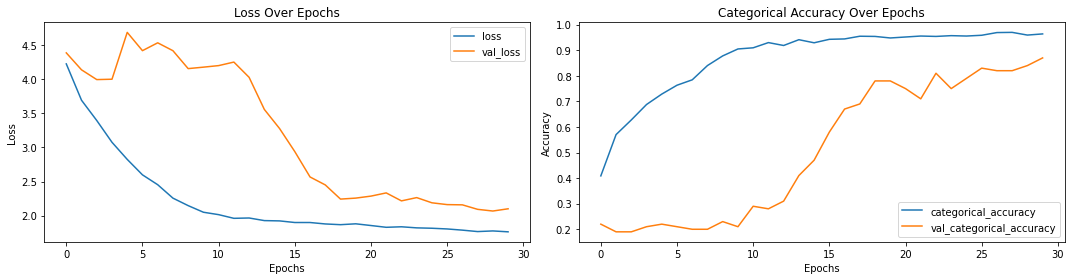

In [26]:
plot_evaluation(history_model_rnn_cnn4)

### Insights
<hr>
<u>Key Observations:</u>

<b>Learning Dynamics:</b>
<ul>
    <li>Initial rapid improvements in validation loss (4.38706 → 2.06818) suggest that the model is learning the feature representations well.</li>
    <li>The use of regularization (L2) in Conv2D and Dense layers improved generalization, as seen in the increasing validation accuracy.</li>
</ul>

<b>Regularization Impact:</b>
<ul>
    <li>L2 regularization effectively reduced overfitting, allowing the model to maintain stable validation accuracy and loss over more epochs compared to the previous model.</li>
    <li>This helped the model avoid memorizing training data, as evidenced by improved validation accuracy.</li>
</ul>

<b>Learning Rate Schedule:</b>
<ul>
    <li>The learning rate scheduler (ReduceLROnPlateau) allowed the model to continue improving validation loss and accuracy during later epochs.</li>
    <li>The decrease in learning rate after Epoch 7 enabled the model to fine-tune parameters effectively without overshooting optimal weights.</li>
</ul>

<b>Model Convergence:</b>

<ul>
    <li>Validation accuracy peaked at 0.8700 (Epoch 30), indicating that the model converged well.</li>
    <li>The slight fluctuation in validation loss and accuracy suggests that further fine-tuning may provide marginal benefits.</li>
</ul>

<b>Model Architecture Highlights:</b>
<ul>
    <li>TimeDistributed Layers: Enabled spatial feature extraction across frames in a sequence.</li>
    <li>LSTM Layer: Captured temporal dependencies effectively, leading to improved classification performance.</li>
    <li>Dropout Regularization: Further controlled overfitting in dense layers, balancing model complexity and performance.</li>
</ul>

In [30]:
# Saving the same model with 87% accuracy on validation set in keras format as well for future use

from tensorflow.keras.models import load_model

# loading the best saved model first :
best_model = load_model('model_init_2024-12-0320_10_21.857188/model-00029-1.77637-0.95928-2.06818-0.84000.h5')

# saving the model in .keras format as well
best_model.save('model-00029-1.77637-0.95928-2.06818-0.84000.keras', save_format='keras')

## Model 12 - Utilizing Transfer learning

Here MobileNetV2 is the pretrained model, I have been experimenting with to understand the learning curve of this model, as well as its performance

In [46]:
from tensorflow.keras.applications import MobileNetV2 

class TL_RNN_CNN(ModelBuilder):
    def define_model(self, lstm_cells=128, dense_neurons=128, dropout=0.3):
        model = Sequential()

        # Use MobileNetV2 as a pre-trained feature extractor
        base_model = MobileNetV2(weights='imagenet', include_top=False) # include_top=False removes the 
                                                                        # top classification layers, 
                                                                        # keeping only convolutional layers.

        # Freeze the base model to retain pre-trained weights
        base_model.trainable = False

        # Add TimeDistributed wrapper for sequential data
        model.add(TimeDistributed(base_model, input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(GlobalAveragePooling2D()))

        # Add LSTM for temporal sequence learning
        model.add(LSTM(lstm_cells, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
        model.add(Dropout(dropout))

        # Fully Connected Dense Layers
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [47]:
# Initialize parameters
tl_rnn_cnn = TL_RNN_CNN()
tl_rnn_cnn.initialize_path(project_folder)
tl_rnn_cnn.initialize_image_properties(image_height=120, image_width=120)
tl_rnn_cnn.initialize_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=20)

# Define the model
tl_rnn_cnn_model = tl_rnn_cnn.define_model(lstm_cells=128, dense_neurons=128, dropout=0.3)
tl_rnn_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 3, 3, 1280)   2257984   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 1280)         0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 128)               721408    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

#### <u>Note:-</u> 

The warning occurs because MobileNetV2 (or any similar pre-trained model) expects a specific input shape, typically (224, 224) for images, as this is the shape the model was trained on using the ImageNet dataset. However, my input shape (120, 120) doesn't match these default expectations.

In [48]:
# Train the model
print("Total Parameters:", tl_rnn_cnn_model.count_params())
history_tl_rnn_cnn = tl_rnn_cnn.train_model(tl_rnn_cnn_model, augment_data=True)

Total Parameters: 2996549
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6248 - categorical_accuracy: 0.2451
Epoch 00001: val_loss improved from inf to 1.49549, saving model to model_init_2024-12-0400_53_46.594852/model-00001-1.62478-0.24510-1.49549-0.38000.h5
34/34 [==============================] - 182s 5s/step - loss: 1.6248 - categorical_accuracy: 0.2451 - val_loss: 1.4955 - val_categorical_accuracy: 0.3800 - lr: 1.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4164 - categorical_accuracy: 0.4042
Epoch 00002: val_loss improved from 1.49549 to 1.33686, saving model to model_init_2024-12-0400_53_46.594852/model-00002-1.41640-0.40422-1.33686-0.51000.h5
34/34 [==============================] - 179s 5s/step - loss: 1.4164 - categorical_accuracy: 0.4042 - val_loss: 1.3369 - val_categorical_accuracy: 0.5100 - lr: 1.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.2608 - categorical_accuracy: 0.5181
Epoch 

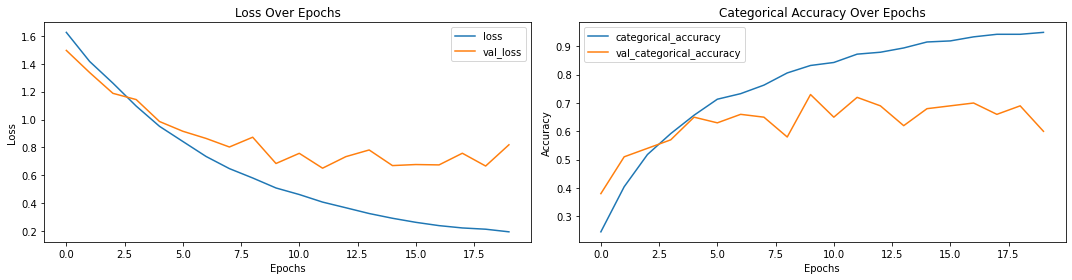

In [49]:
plot_evaluation(history_tl_rnn_cnn)

#### Observations for lower accuracy on the pre-trained model:

Overfitting to the Training Data:

- Despite a high training accuracy (94.95%), the validation accuracy plateaued at around 73% and even dropped to 60% toward the later epochs.
- This suggests the model overfit to the training data, likely due to insufficient regularization or that the dataset did not generalize well to validation samples.

Suboptimal Fine-Tuning and Feature Alignment:

- While MobileNetV2 is a powerful pre-trained model, its feature maps might not align optimally with the characteristics of this case (e.g., sequence-based input or domain-specific features).
- Without extensive fine-tuning (e.g., unfreezing deeper layers or adapting preprocessing), the pre-trained weights might not fully adapt to this specific problem.